### OpenCV Darknet Yolo를 이용하여 이미지Object Detection

#### 입력 이미지로 사용될 이미지 다운로드

In [1]:
# 입력 이미지 다운로드
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2025-03-02 09:55:17--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.02s   

2025-03-02 09:55:18 (17.4 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



#### Darknet Yolo사이트에서 coco로 학습된 Inference모델과 환경파일 다운로드

In [2]:
!mkdir ./pretrained

# yolov3 config 파일과 pretrained 가중치 다운로드
!wget -O /content/pretrained/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O /content/pretrained/yolov3.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true

# yolov3-tiny config 파일과 pretrained 가중치 다운로드
!wget -O /content/pretrained/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights
!wget -O /content/pretrained/yolov3-tiny.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true

--2025-03-02 09:55:23--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/pretrained/yolov3.weights’

/content/pretrained 100%[===================>] 236.52M  24.4MB/s    in 8.9s    

2025-03-02 09:55:42 (26.6 MB/s) - ‘/content/pretrained/yolov3.weights’ saved [248007048/248007048]

--2025-03-02 09:55:42--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg [following]
--2025-03-02 09:55:42--  https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg
Reusing ex

#### readNetFromDarknet(config파일, weight파일)을 이용하여 yolo inference network 모델을 로딩

#### COCO class id와 class 명 매핑

In [4]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

#### 단일 이미지를 Yolo로 detect하는 get_detected_img() 함수 생성.

In [7]:
def get_detected_img(cv_net, img_array, conf_threshold, nms_threshold, is_print=True):

    rows = img_array.shape[0]
    cols = img_array.shape[1]

    draw_img = img_array.copy()

    # 모델의 전체 층 이름 가져오기
    layer_names = cv_net.getLayerNames()

    # 출력층 이름만 가져오기
    outlayer_names = [layer_names[i - 1] for i in cv_net.getUnconnectedOutLayers()]

    # 모델의 입력값 설정
    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))

    # 수행 시간 측정
    start = time.time()

    # Object Detection 수행하여 결과를 cvOut으로 반환
    # 이때 지정한 출력 레이어(outlayer_names)에서 결과를 가져옴.
    cv_outs = cv_net.forward(outlayer_names)

    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    class_ids = []
    confidences = []
    boxes = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외
            if confidence > conf_threshold:
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # 한 객체에 3개의 출력 층으로 인해 바운딩 박스가 겹침.
    # NMS로 최종 바운딩 박스 선택
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
            cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img

In [8]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import os

# image 로드
img = cv2.imread('/content/data/beatles01.jpg')

# 가중치, config 파일 경로 설정
weights_path = '/content/pretrained/yolov3.weights'
config_path =  '/content/pretrained/yolov3.cfg'

# darknet yolo pretrained 모델 로딩
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

Detection 수행시간: 3.16 초


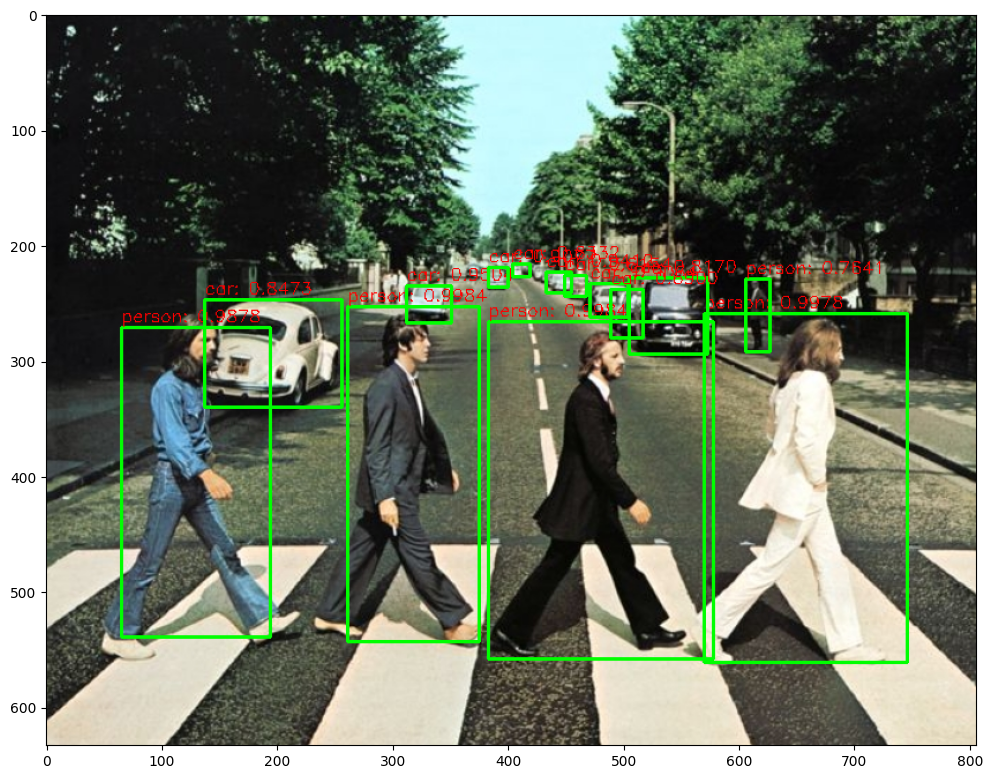

In [9]:
# 임계값 설정
conf_threshold = 0.5
nms_threshold = 0.4

# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### tiny Yolo로 Object Detection 수행하기.

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import os

# image 로드
img = cv2.imread('/content/data/beatles01.jpg')

weights_path = '/content/pretrained/yolov3-tiny.weights'
config_path =  '/content/pretrained/yolov3-tiny.cfg'

# darknet tiny yolo pretrained 모델 로딩
cv_net_yolo_tiny = cv2.dnn.readNetFromDarknet(config_path, weights_path)

Detection 수행시간: 0.37 초


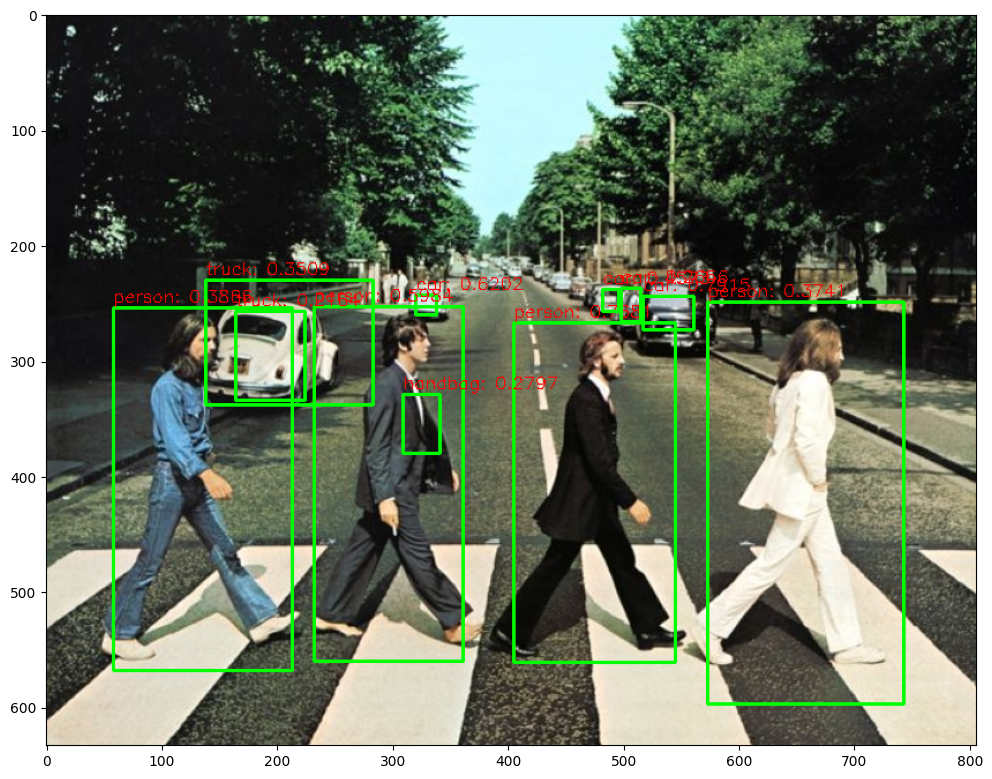

In [11]:
conf_threshold = 0.2
nms_threshold = 0.4

# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net_yolo_tiny, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)